# RGB Analyse 
**created by Hongyi Huo on 4/23/2023**

In [ ]:
# install required library
# !pip install web3

In [12]:
# !pip install opencv-python


In [1]:
# !pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
# import libraries
import requests
import json
from web3 import Web3

import numpy as np
import os
import time
import h5py



In [3]:
# get api_interfaces by tangyizhi
# API factors
API_key = 'PlIE5PSJaLBOTy67DORlQwY3MchgQxfP'
API_url = "https://eth-mainnet.g.alchemy.com/v2/PlIE5PSJaLBOTy67DORlQwY3MchgQxfP"
API_nft_url = 'https://eth-mainnet.g.alchemy.com/nft/v2/PlIE5PSJaLBOTy67DORlQwY3MchgQxfP'

# data collection functions
def getNFTsForCollection(contractAddress, withMetadata):
    url = API_url + '/getNFTsForCollection?contractAddress=' + contractAddress + '&withMetadata=' + str(withMetadata)
    r = requests.get(url, headers={"accept": "application/json"})
    return r
def getNFTSales(contractAddress, tokenid):
    # from block 0 to latest block, with ascending order
    url = API_url + '/getNFTSales?fromBlock=0&toBlock=latest&order=asc&contractAddress=' + contractAddress + '&tokenId=' + str(tokenid)
    r = requests.get(url, headers={"accept": "application/json"})
    return r

def getFloorPrice(contractAddress):
    url = API_nft_url + "/getFloorPrice?contractAddress=" + contractAddress
    r = requests.get(url, headers={"accept": "application/json"})
    return r

def computeRarity(contractAddress, tokenid):
    url = API_nft_url + '/computeRarity/?contractAddress=' + contractAddress + '&tokenId=' + str(tokenid)
    r = requests.get(url, headers={"accept": "application/json"})
    return r

def getMetaData(contractAddress, tokenid):
    url = API_nft_url + '/getNFTMetadata?contractAddress=' + contractAddress + '&tokenId=' + str(tokenid) + '&refreshCache=false'
    r = requests.get(url, headers={"accept": "application/json"})
    return r

def getNFTAttributes(contractAddress):
    url = API_nft_url + '/summarizeNFTAttributes?contractAddress=' + contractAddress
    r = requests.get(url, headers={"accept": "application/json"})
    return r

*The following is api test and further utils for data collection and prep*

In [4]:
response = json.loads(getNFTsForCollection('0x60E4d786628Fea6478F785A6d7e704777c86a7c6', True).content)
print(response['nfts'][0])

{'contract': {'address': '0x60e4d786628fea6478f785a6d7e704777c86a7c6'}, 'id': {'tokenId': '0x0000000000000000000000000000000000000000000000000000000000000000', 'tokenMetadata': {'tokenType': 'ERC721'}}, 'title': '', 'description': '', 'tokenUri': {'gateway': 'https://boredapeyachtclub.com/api/mutants/0', 'raw': 'https://boredapeyachtclub.com/api/mutants/0'}, 'media': [{'gateway': 'https://nft-cdn.alchemy.com/eth-mainnet/c480d814f8a4e2b5f02dd3aa189ca742', 'thumbnail': 'https://res.cloudinary.com/alchemyapi/image/upload/thumbnailv2/eth-mainnet/c480d814f8a4e2b5f02dd3aa189ca742', 'raw': 'ipfs://QmURua8bNrAwX76Tp6G9t6Lospdxyt61JGy3UsXY7skfR1', 'format': 'png', 'bytes': 577530}], 'metadata': {'image': 'ipfs://QmURua8bNrAwX76Tp6G9t6Lospdxyt61JGy3UsXY7skfR1', 'attributes': [{'value': 'M1 Purple', 'trait_type': 'Background'}, {'value': 'M1 Cheetah', 'trait_type': 'Fur'}, {'value': 'M1 Scumbag', 'trait_type': 'Eyes'}, {'value': 'M1 Toga', 'trait_type': 'Clothes'}, {'value': 'M1 Bored Unshaven', 

In [6]:
# check the attribute lists.
response = json.loads(getNFTAttributes('0x60E4d786628Fea6478F785A6d7e704777c86a7c6').content)
print(response['summary'].keys())

dict_keys(['Fur', 'Eyes', 'Background', 'Mouth', 'Clothes', 'Earring', 'Hat', 'Name'])


In [7]:
response = json.loads(computeRarity('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',0).content)
print(response)

[{'value': 'M1 Purple', 'trait_type': 'Background', 'prevalence': 0.09621621621621622}, {'value': 'M1 Cheetah', 'trait_type': 'Fur', 'prevalence': 0.03099099099099099}, {'value': 'M1 Scumbag', 'trait_type': 'Eyes', 'prevalence': 0.016885456885456885}, {'value': 'M1 Toga', 'trait_type': 'Clothes', 'prevalence': 0.01662805662805663}, {'value': 'M1 Bored Unshaven', 'trait_type': 'Mouth', 'prevalence': 0.11613899613899614}]


In [8]:
response = json.loads(getNFTSales('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',555).content)
print(response['nftSales'][-1]['sellerFee'])
print(response['nftSales'][-1]['protocolFee'])
print(response['nftSales'][-1]['royaltyFee'])

{'amount': '23740500000000000000', 'tokenAddress': '0x0000000000000000000000000000000000000000', 'symbol': 'ETH', 'decimals': 18}
{'amount': '624750000000000000', 'tokenAddress': '0x0000000000000000000000000000000000000000', 'symbol': 'ETH', 'decimals': 18}
{'amount': '624750000000000000', 'tokenAddress': '0x0000000000000000000000000000000000000000', 'symbol': 'ETH', 'decimals': 18}


In [72]:
# get the sell price from the api
def get_price(contractAddress, tokenid, roundto):
    response = json.loads(getNFTSales(contractAddress,tokenid).content)
    res = int(response['nftSales'][-1]['sellerFee']['amount'])/ (10**int(response['nftSales'][-1]['sellerFee']['decimals']))
    res = round(res, roundto)
    return res

print(get_price('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',1,5))
print(get_price('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',28905,5))
print(get_price('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',36,5))




6.65
106.875


KeyError: 'decimals'

In [30]:
# get feature and labels for building the dataset
def get_monkey(contractAddress, tokenid, roundto):
    # initialize all attributes to one, which means least rare
    feature = {'Fur':1, 'Eyes':1, 'Background':1, 'Mouth':1, 'Clothes':1, 'Earring':1, 'Hat':1, 'Name':1}
    feature_response = json.loads(computeRarity(contractAddress,tokenid).content)
    #print(feature_response)
    for i in feature_response:
        feature[i['trait_type']] = round(1 / i['prevalence'], roundto)
        
    # get price
    
    return feature, price

there are monkeys that has never been traded, thus *try* get the price, 

if price donnot exist then the price is set to **None**

In [32]:
print(get_monkey('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',0,5))
print(get_monkey('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',10000,5)[1] is None)

({'Fur': 32.26744, 'Eyes': 59.22256, 'Background': 10.39326, 'Mouth': 8.61037, 'Clothes': 60.13932, 'Earring': 1, 'Hat': 1, 'Name': 1}, 5.32)
False


make the dataset using the template ['Fur', 'Eyes', 'Background', 'Mouth', 'Clothes', 'Earring', 'Hat', 'Name'] as **features**

seller price as **labels** to predict


In [12]:
# now gathering the data and build dataset

attribute_list = ['Fur', 'Eyes', 'Background', 'Mouth', 'Clothes', 'Earring', 'Hat', 'Name']
features = []
labels = []
token_id = 1
while len(labels) <= 150:    
    feature, price = get_monkey('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',token_id, 5)
    if price is not None:
        features.append([feature[x] for x in attribute_list])
        labels.append(price)
    token_id += 1
    time.sleep(0.01)
print(features, labels)

[[20.90958, 40.21739, 11.1, 25.9, 56.63265, 1, 84.45652, 1], [9.95643, 7.71752, 10.76177, 5.86327, 33.31904, 1, 99.61538, 1], [17.45283, 41.24204, 10.1489, 8.61037, 1, 1, 52.35849, 1], [9.80565, 40.21739, 10.8459, 31.79214, 51.11842, 1, 85.57269, 1], [10.85802, 17.43716, 10.3766, 98.60406, 73.30189, 29.25452, 35.51188, 1], [33.95979, 33.03571, 10.3766, 18.58852, 92.5, 1, 23.0975, 1], [22.27638, 15.18765, 10.1489, 5.86327, 66.52397, 1, 53.66022, 1], [33.95979, 7.71752, 10.3766, 98.60406, 38.77246, 1, 45.06961, 1], [26.35685, 51.8, 10.1489, 8.61037, 63.06818, 1, 1, 1], [68.88298, 109.74576, 32.10744, 61.86306, 183.25472, 46.69471, 1, 1], [9.80565, 18.80445, 10.8459, 50.71802, 59.22256, 1, 84.45652, 1], [28.07081, 24.77679, 11.1, 18.58852, 60.13932, 1, 67.44792, 1], [34.01926, 181.54206, 29.88462, 97.125, 236.89024, 1, 127.79605, 1], [57.8125, 7.71752, 10.8459, 5.86327, 60.13932, 1, 67.44792, 1], [33.95979, 27.71041, 11.1, 50.85079, 56.63265, 1, 57.47041, 1], [34.01926, 123.72611, 32.7020

In [ ]:
# partially acquire data... getting too fast would cause api denial
while len(labels) < 1200:    
    feature, price = get_monkey('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',token_id, 5)
    if price is not None:
        features.append([feature[x] for x in attribute_list])
        labels.append(price)
    token_id += 1
    time.sleep(0.01)
print(features, labels)

In [13]:
API_key = 'PlIE5PSJaLBOTy67DORlQwY3MchgQxfP'
API_url = "https://eth-mainnet.g.alchemy.com/v2/PlIE5PSJaLBOTy67DORlQwY3MchgQxfP"
API_nft_url = 'https://eth-mainnet.g.alchemy.com/nft/v2/PlIE5PSJaLBOTy67DORlQwY3MchgQxfP'

def getMetaData(contractAddress, tokenid):
    url = API_nft_url + '/getNFTMetadata?contractAddress=' + contractAddress + '&tokenId=' + str(tokenid) + '&refreshCache=false'
    r = requests.get(url, headers={"accept": "application/json"})
    return r

In [36]:
response = json.loads(getMetaData('0x60E4d786628Fea6478F785A6d7e704777c86a7c6', 1).content)
ipfs_address = response['metadata']['image']
print(ipfs_address)


ipfs://QmVFPvu8aeJHXyNVxpfftVHaKjRsbtH6dXWscJ2TukM3xi


In [52]:
import numpy as np
import json


ipfs_array = np.zeros(500, dtype=object)

for i in range(1, 501):
    token = str(i)
    response = json.loads(getMetaData('0x60E4d786628Fea6478F785A6d7e704777c86a7c6', token).content)
    ipfs_address = response['metadata']['image']
    ipfs_array[i-1] = ipfs_address
    time.sleep(0.01)
    
print(ipfs_array)


['ipfs://QmVFPvu8aeJHXyNVxpfftVHaKjRsbtH6dXWscJ2TukM3xi'
 'ipfs://QmdsxYwtbDKmx6fz6CP5FLCH3hkkuZ3EDBFBTcHHRrsSRM'
 'ipfs://QmR7Kj6UGDf728SMLq6bvAbhYjmYSZXiEhFPLhgNVXA6rJ'
 'ipfs://QmWRGQUs6yRUinC8d3woj6dgZhEwzozbBZ7csnaByVaob8'
 'ipfs://QmYMqgiRbCh4ScxpgzogWYieTh3gQHyc65g6UJUG5WEZFh'
 'ipfs://QmYsSH9W7f2HNQFMYyYDWW6UFnLdN1nhAmWrajvS5Lzvzy'
 'ipfs://QmQHjXmaBs6v8hXh7145qDcYmT49bqgv7GjQPCt2ZAzQ36'
 'ipfs://QmZgSA6rMsZ8QQGH4Fa2npVEQkur1NPSnzMQ8dUorRULxx'
 'ipfs://QmPduVDFiB5aVJkSWjP4eao5uoBwVbjaXMT1aF8axxsp4k'
 'ipfs://QmRhySUuENFfVx4K4fpD7uV49RVkqKkEjLAU1p2vnZr7DL'
 'ipfs://QmZv7jNmyVyRHqJwc48ib8gDsyrcK4FYxYoeGsjt6XYAuE'
 'ipfs://QmWNd8aeqDq5ZHZyEwDqcUbdYBgWxx4vNyxZHRw8352jqr'
 'ipfs://QmRgVUkLGENUso7VoSuu8HBdYpjgbihgUXJW9xFJgJtVjS'
 'ipfs://QmYqMgWxc3EQN5CAUr4qgW1nt9HeY5RqYEkZPUkx6gu1h9'
 'ipfs://QmXha4p73PYx3xsNoiKivJ8cGRZqD1pNnP53cxB3RvMeCZ'
 'ipfs://Qmexdfr98vYFkQSWtDhFDGoQ2XfhxkM14Z5Bmf321ypaKT'
 'ipfs://QmaJYj8CXRmeWtngkTFbedu88qcTmEvmBRxVWNji4v6uGv'
 'ipfs://QmUEKSAptuMQeYVk33hHs6

In [3]:
import requests
import shutil
import os

In [50]:
import requests
import shutil
import numpy as np
from PIL import Image

url = 'https://gateway.ipfs.io/ipfs/'

def download_img(ipfs_address, fp):	
    if ipfs_address.startswith('ipfs://'):
        target_file = ipfs_address[7:]
        print("downloading from", url+target_file)
        r = requests.get(url+target_file, stream=True, verify=False, headers={"Accept-Encoding": "identity"})
        filename = fp + target_file.replace('/', '_')
        if not filename.endswith('.png'):
            filename += '.png'
        with open(filename, 'wb') as out_file:
            shutil.copyfileobj(r.raw, out_file)
        return filename
    else:
        print("Not IPFS File")
        
# download_img("ipfs://QmVFPvu8aeJHXyNVxpfftVHaKjRsbtH6dXWscJ2TukM3xi", "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/")


In [125]:
for i in range(1, 501):    
    download_img(ipfs_array[i], "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/")
    
    path = "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/"
    
    ipfs_hash = ipfs_array[i][7:]

    # 加上.png后缀
    old_name = path + ipfs_hash + ".png"
    

    # 新文件名
    new_name = path + str(i) + ".png"

    # 重命名文件
    os.rename(old_name, new_name)


    time.sleep(0.01)


downloading from https://gateway.ipfs.io/ipfs/QmdsxYwtbDKmx6fz6CP5FLCH3hkkuZ3EDBFBTcHHRrsSRM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmR7Kj6UGDf728SMLq6bvAbhYjmYSZXiEhFPLhgNVXA6rJ
downloading from https://gateway.ipfs.io/ipfs/QmWRGQUs6yRUinC8d3woj6dgZhEwzozbBZ7csnaByVaob8


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYMqgiRbCh4ScxpgzogWYieTh3gQHyc65g6UJUG5WEZFh
downloading from https://gateway.ipfs.io/ipfs/QmYsSH9W7f2HNQFMYyYDWW6UFnLdN1nhAmWrajvS5Lzvzy


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQHjXmaBs6v8hXh7145qDcYmT49bqgv7GjQPCt2ZAzQ36


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZgSA6rMsZ8QQGH4Fa2npVEQkur1NPSnzMQ8dUorRULxx
downloading from https://gateway.ipfs.io/ipfs/QmPduVDFiB5aVJkSWjP4eao5uoBwVbjaXMT1aF8axxsp4k


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRhySUuENFfVx4K4fpD7uV49RVkqKkEjLAU1p2vnZr7DL


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZv7jNmyVyRHqJwc48ib8gDsyrcK4FYxYoeGsjt6XYAuE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWNd8aeqDq5ZHZyEwDqcUbdYBgWxx4vNyxZHRw8352jqr
downloading from https://gateway.ipfs.io/ipfs/QmRgVUkLGENUso7VoSuu8HBdYpjgbihgUXJW9xFJgJtVjS


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYqMgWxc3EQN5CAUr4qgW1nt9HeY5RqYEkZPUkx6gu1h9


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXha4p73PYx3xsNoiKivJ8cGRZqD1pNnP53cxB3RvMeCZ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmexdfr98vYFkQSWtDhFDGoQ2XfhxkM14Z5Bmf321ypaKT


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaJYj8CXRmeWtngkTFbedu88qcTmEvmBRxVWNji4v6uGv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUEKSAptuMQeYVk33hHs6t8qWk1oUWstNNbZuRc8VJYvz


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZvibdDxkXGQcQ2hhbYCVpEGowmMJnKSbv9AXuRsBwyrD
downloading from https://gateway.ipfs.io/ipfs/QmYEHLvbKK8WQn151A4VkDxULPvFE6UQB16Jtp5yysmZq2


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmb9Ze7gEdiir1VvYy7yr96Wfz2GHP3BAewm5fW45P4Qfh


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmd9btjdBqPdptYi4D5Cf4e7wEpdVS9FCSHXVBp4VZPaoh


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSAMUWNKu8gRjmGZNJZFFMj71oPMYGgLsnVGnSSzABp1L


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWpQpRNdGByj1Qbkwr3oSUcZ8LXJoFPsabpkkahDyg982


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNsyQRSWxeMBNNZBKrvJgpGekXVqd1F6hFkoxHx4sVtTj


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmfLWux9bieziHjiMvDCSsaznc44UzRieN9CSdLufduxLn
downloading from https://gateway.ipfs.io/ipfs/QmT8yP1nWP8pM2WkSPBcY7azFMQPffi1qYAEwWhDdipzc9


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYxC6gbVySrge1tEmcQof5QVyyXB6HLSCsnfb23gLJoPz


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRAMfHRjcYJqn9mF8gx5ubjocwCSZboXh8xjJFQSMbDPx
downloading from https://gateway.ipfs.io/ipfs/Qmd8KdKWJehtozFcnEMW73xW5vWiiE7rySAvxdRokLsypq


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmS7NEcqixyDJJYA9J95Xdq9REzNXDu5g5DvtmgM4YMmoJ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRvshwZSr8bfEoWL3wxp1Ed8x3fTHrYiSFSNSMMRmFHmP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qme3uojsPhMZWwuVzoMZBnugw8sPTZKrMG1nvF5T8azpXC


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdyukEeXCRa6zNnaim4m8NQv8Cig5TPoeGqns4Z4uFcT2


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeBEXz4HDQxGw2CzJYnbEhrZKBBUjrFrmTDZL9g2N9hoe
downloading from https://gateway.ipfs.io/ipfs/QmXhHXR182usM5CZTBybULxRsY8YgPxeMDerV2rZpSP2qt


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZquSaHP4KhQrUL2uLLHtpzk5a51wRxci3GhcWXYLX6rU
downloading from https://gateway.ipfs.io/ipfs/QmZbTCqkuein6FeymMMooZ9WpEYKMqBfBVM966avyH4LEC
downloading from https://gateway.ipfs.io/ipfs/QmX3NsPj7KnNAfweJWvLjVtKPcSMnEHEGaijqApZhDeaWJ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVSNoHVkyMGU438dprBnEJwMgLf9yHghBRhBiVdQ8jEAG
downloading from https://gateway.ipfs.io/ipfs/QmQM1fLRXQZtGgXYEfkn3bDcjrgDnwPC83B9ygJ8k9HfuR


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaewF8wZnuK68tHRmTZUY4ECg8ctE7zE76deYdzWU9Reb
downloading from https://gateway.ipfs.io/ipfs/QmWhwRA4mFeaxzSyMD8JEUW3FMorQhGPHqdBHucTxT4sqz


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZGvVYMomkpNVp6UxaACFoqVVrkW991B413N61FdgfXqj
downloading from https://gateway.ipfs.io/ipfs/Qmd7gVwbv67w7KdoGWQaVKt5KLEjS2xBGsTtAzXgmuYaez


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmV6NSQ71JKUPA3e5ESdqS5MFyCyJRnqKT3NB2AKSjkwCU
downloading from https://gateway.ipfs.io/ipfs/QmSB5yvdmdmfaaBMCAmy3TYUGW4pb3x2X8qa3ZNRerQRii


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmREYXJ5c72qquNVyyRJdvWKnU6dTidScW4DbhS5dCB6xc
downloading from https://gateway.ipfs.io/ipfs/QmZF3X8p6tGk2mSV348prY4gTFgMFKvEzevogxUiceQMug


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaWQrwDG7Af2riJoRp8ccGXLjY2F3HA1Q3t1apdbZ6fgk


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmd1LWBNmPzNL5UQ67CBbzmhMgJyopJs7FzvuBBQgAGFdL


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVjfD493q5XriVfeHqDZWnyQy8kxopo2ejcGdeFns8Jto
downloading from https://gateway.ipfs.io/ipfs/QmRAfo7GmiT4QhxXh4CdPH23oWqAhG2X1TddWXi7MTm7uX


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcdiGZwoiLyPMpcJ55zSYRmubzPQEDZi3X4nPMF7mbXMn
downloading from https://gateway.ipfs.io/ipfs/QmbsnsRi9MxbN6YhT7hE57vandZyTi1vsLESZsw63YJ8kF


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWu1B1pYd2Z4Sideo3n7knWKuycqw7k5S4GHzbs5eucLy
downloading from https://gateway.ipfs.io/ipfs/QmRM4bc6ihmMxc9CdyG5d4pUxhuzPgiJ2QgVXPnsRvw1ib


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZtSS9CdPHG2NnFfETNtvqNnoYTP1YtL5DDRXghRStRVs


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmczC63DrtvqhTFQnRmjDicUZZSzs5imWvRjNRU5uxyKrp


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdFf1gv8P6bhkH2Yiim5sYujWL7kVNqfnzC5o4WKhN2cK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmX66b5q2djZnVhtrPNCpEn6xT7EK8Du75YNAeh129JYKr
downloading from https://gateway.ipfs.io/ipfs/QmXSKPvJ9mCNtTvmff1faPdqNSgULDVxLk3foUB7ioCBVu


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZETpEDZHL9vfsMnbmaXm8cHEnGuLszdHaRAFFhPNxPCd


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSQefUucRjKN1nUjCMfmSGr3Fva5R4D5eGykZ8kNB9Ebn
downloading from https://gateway.ipfs.io/ipfs/QmZRswno7JARcM33mTyMz8b7KM7hMED1KCtEPHbXhLkzo6


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQHuRJSPqqVeUy41AG7hJzJYjfrJCjsrm3YzS9QycanP6
downloading from https://gateway.ipfs.io/ipfs/QmS6cUiWgc5JtPTgsN4nwqsbkBTs1ZGaEhKbqqGb3psK4K


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWfnJUaNfbe5was3rRAUHaqmYB4x3KuVojczPonwCoDCn
downloading from https://gateway.ipfs.io/ipfs/QmbUCe7JMPsG39FRaLaJ9VwSKrE74PzEb1s4DKuEkARepS


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmT5gWfSDk7DMoSGmxkFLJh6zgDHKHkiZkJQx1dqUVbacR
downloading from https://gateway.ipfs.io/ipfs/QmVorZkkBti2csakoGDF8cy7dxVoqTvnKRMWtSoshV7T6u


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYCdJK9JFU7C8YiXvh3SSnXhb8izipeP1QqETiU2LoBxH
downloading from https://gateway.ipfs.io/ipfs/Qmd5t6J598cNW4Lu5TmiEyzwW1khBg6jMKi8wV5kXhNq82


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmV5kzjtLyMP1qRBXVgJ6FcYuPxPRx4GvFmkxPdcAWtD4M


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeSZhfCK1kLNeexuJzaZ5MAWpqJHLxPkahgqBtQ6UP4Af
downloading from https://gateway.ipfs.io/ipfs/QmYBNDaveAb3WNegPncGzGi41tfzBp8ac3yrcTr3XQkeok


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQZPY7Z28pVct38cSWLWveBGbWUDoc5oy6oTFdP7GcMWk
downloading from https://gateway.ipfs.io/ipfs/QmPdNeCj2UWjgzPCiLYNxsMzr4inw5mJ2vuTwsgr7TGUiU


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmesL4myf7nUA5ENfvEGeN7RmsG1xnYSjpAit6F8g5KxW5


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmemmSDCm6JH8s5MaERUdNPDqnwGdgBbXEm91gptTbitKP
downloading from https://gateway.ipfs.io/ipfs/QmNzNqxfDQAREx14FyRKoma6eZb9GcQNfS7vwLU12cT4Jx


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNnhTSD77LVwE46mG1KEg6e9sacyJ66g4H2t8TUxB5F75


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmV9bt4wUrAXJPNWhVsn6JfHhQcj472XaX37wSNfnY9Vy8
downloading from https://gateway.ipfs.io/ipfs/QmSiESWz2EMk7DvM4WHY9DWemQLbokjco9wCmtWT7pS6zT


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTRWAnALf1PtXx5V2Fz7pXsDSqXgzvqk7zk1MZwBBRdPC
downloading from https://gateway.ipfs.io/ipfs/QmQ8YFdmhu8fZYnLxfC1qJY22YvNXQvmmf3nsfWdoFdrkM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRdMXY7Znkb7nUrYAN6ovEGNKCdTug6cFUPVQGrxnSf25
downloading from https://gateway.ipfs.io/ipfs/QmRnzqcs4tpFpCdZeszm9BzvFtoaSVjFXskML9UWKJBuVR


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbFTGUHrr5iXYw8bgc5oZWmLWBA1XHttQLUCeDKEQ6qSn
downloading from https://gateway.ipfs.io/ipfs/QmVkovqsxdesVEzQ1XWy9q8RxwgRNXWgUuWeBgPer1vkWh


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcBX5KfXJ5i5nzU43pSfNJHVKThcXuQbBtr3T8UQNzPef


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXYBFXZzV6zv7WazPNzp9hkRwyiD2HU4rusNnapvo7Ziw
downloading from https://gateway.ipfs.io/ipfs/Qmd6gWn2Zsam1ZsBKrqemVmfap436Z9uqyafdwGHsnCdVA


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQEyEiJ4PBRKDyAr53Y3ZZrkDxpkRZeGNPYrBoeo1ptSW
downloading from https://gateway.ipfs.io/ipfs/QmNfmbJdb6fZAUBSjnGXyT2xhaX3fJ6Qrjpy3umhvPxVw9


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTRTRA8VeH4J9vWUA4ueQW6PryiJaympmn3G9sSmKeXjz
downloading from https://gateway.ipfs.io/ipfs/QmTcvEyoacxvZd3MHKThjUA3cvH1G6ZtuBmgZbEB7Z2nxM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSi3YmDKWEpGj6V8bhT7miexrqkztFy729ygrSkW2RxVh
downloading from https://gateway.ipfs.io/ipfs/QmaC1oGho3ngrnNSYpyJ9TdVV1EsX9FXngCUHGY8pBv28P


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYiJni4mZSFPSy3jz9wAVVDVEYCczuTYSXJ1Q2skwicTB
downloading from https://gateway.ipfs.io/ipfs/QmVwKkmLDHDCeWXrmbWEGwqUtfMZ5iq69eicdfVyeiTqFW


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYZxmy7wHnBZULsfU6VziXSYTUndxv5Kpvhvu9xnv2rRH


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSL796QtExLeNz9jxNLqG8dedpAi5kCvCJLaEvoJDAwhg
downloading from https://gateway.ipfs.io/ipfs/QmdqRo9vgFToWevn2ugywKK5Wbnh2NuvsAHmChXmVdWm1m


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZBhD7xgLqV15Uz6HpSpsjuJ6khQsg6cDWnK39t6T9TsD
downloading from https://gateway.ipfs.io/ipfs/QmdVU6iRPyFX9Y8RqE99hqZP29YbdxcYRP6e2JfCEvumtw


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmf5vUMFVsENk5tAUXApK4HvXpM5x4Hr7Bt3uQxHG7gpcX


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmThhiGaH5ePaTUTggrvFzsYf17ipcc4UeRdX5yRKwZ3yu


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYExK8bCAdGzs9iURKxLZr5g8MNids8pWnrzhWgqKzfeK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaBxGRSQmhbdaX4gJQpCpjXiGuXmCdMxmq7CLc1N3WUQj
downloading from https://gateway.ipfs.io/ipfs/QmXRWcCH8BypNnYZ1BbcDpqiTbtodM5UCd4E63sKazyqxz


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRoSU8AmLAuRmCVgiYZ3fgxUGPjBT3VyUWR2NMRAvH5zr


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaVsYwjUU4ymYfCrqTNgpeXWK2c8y7xYRr7ur2R4spk14
downloading from https://gateway.ipfs.io/ipfs/QmUoC35JQ9nwrSCdLqzD6D93BwrrVT6jgkJFkyKoHhg8vv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZh3PK39UAAiegcFSrwGCtSgtEqh3vF6fjRAvAXp5mSkm
downloading from https://gateway.ipfs.io/ipfs/QmUaxd7HoGoyw3dUc4CAcEb3KCqrTC1iyChva8uZmokQA5


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZ9x3CauhhyL94GDt4h3nWC1qHeVgxRydMoZ8gbCwFiNU


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmaj7LswCdfWGoZzmKWNdYRmgq2oGu344pqXHoDhge2gQY
downloading from https://gateway.ipfs.io/ipfs/QmSRw3Z1NGh47SqaRwxrjDyqScozokampTgYu4H4cMSUQ9
downloading from https://gateway.ipfs.io/ipfs/QmdiFqy32PuLCTpm9XNwwP4K1HUh2kAUAvdWkSJwhebBTL


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQuoRhV1Bdc3MfLHFgursUqrHJr6mCVqnQCVqdhAPATAt
downloading from https://gateway.ipfs.io/ipfs/QmZAWzg4LssS9fuufdMVQTbqFiMjs7ZneyN7dSdq3AQGqu


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWMc81H4V5g4bKUsj7bosiyLTzxxV7vSWfF7o6pLToYVK
downloading from https://gateway.ipfs.io/ipfs/QmTnuCnwuzFVr1J8fSfSJvP6mso1Z2pFQUsmSWhxHH8g9y


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbueXkBHK6mWHaRv2Apx5fcGXPEoNSQXAF5q1d8qJfyo5


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZmud54etjuRFuoEobpu4EZPCw5eBrtiyd7pHmiotZrmJ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRQ5gRiATKbePt7BfUtqGHNsuZZAZTHE2yeQHpH9y2jYU


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmP5AnfPzNMu8N2CzsRbY8uKC77HKJRxg8YGEPSLEXQEe3


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZFxAJbz8Ap4gtHd6e1tMy4NNf4MaqEhx8jhRP293dkrq


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbPFxPC58kgBwJRTyeXDft41orSu9rBGnyxM78qAeixm6


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeC79D2bzQJtgdE8V6RXHCe6qpe2o6QJKFUZk5JEmfU9B


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmbxtv14MH9Z6bYNme4u8N8Z4kkivxbxjaNXnn9uyVRA58


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmY3uxFG8EzCKjPjkv14o2FYsG6h8e5wWrGme9THJ8Zuo2


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQqj3AU134NkayWhGLB664mnmtiy2SEfnwP8sa5sMNQk7


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmR34CDn6BmtojW9DVxc3WUvXv6rVy3Wi4D2hQwWReyPYv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXTQMYyMqzsxradLsxQ5MLf1Nx6EzstsWBJw1Sit4Npse


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmfCZMkRevdS5E5thb1ZpkTJ3pUPzf6CM2BSe6TXiXxVCo


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQoWMyJpj4faJfZGwbqAJDEnyPLradH6vYV9qTu1UbMBu


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSFmMkiKfP2QTfmPG22SUedqQ4b2kS7fsduT6hWigUGaP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYc3KcXVB8nSjefF987xmyci9SSPxbdyT54GsEHCs3rFH


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZGAf1e8BWrkDWCDh9Xs4BDbJL2rnG65BsV9haNfuW1fM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPK1weQpF95SDT2A9nYdNbAR4DJZJoS2gC6WpyT6QQjwv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSpVbXXR1nKga82P1bbqzPocyfBLpm4RXhLXbsk2Sj7hC


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXsbhyFz2LrqokZSAJCoFZL4z8myZGuz7qgvd9drfJXPy


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPDuQL4PZjaLD1wkKKukRb22KdZEEXdyotXHw9AnneXVQ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmakw751eonjbb8tCoMMddsr6tJH76cnQ8Pm4kWh8FQ3Mo
downloading from https://gateway.ipfs.io/ipfs/QmRhMrb2NgmwnLgaFMfSp5EzN93q2UYevxZYLmR2e7ouY8


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXAUkbWRbiZrtsTZu8coZkB7pz1gQkm8iS34BCmLyML1d


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPbrh9rjJN6A2Tgtg1imcb3s7juohsSJdL9qduAn7HCUU


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVfc9z3TDd4kDvddHpDAFPPyhC2XjqtLqnLJPucizJcs9


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmai2XWTe27z5g5vSqtGjLYRNEZL6JpGQ2FFWkc8VUX9HV


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeFjgoXhat9mrTsFUX7C2rqTZWQ5NwL2c1KCPokKMJb37


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYaVfRNi7p5hom8pQhS5dXeProtPC93keWc6ucTZXtSDa


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYw677JkQayWMJCAydVLeB74EETn2bEHQwc4RzB1zKmrb


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qme3W87p23cBSu71UgCmCEznmTfM4NGe52RGYpdMotNsC5


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPQLyZFa8prwjNrWNWJt7r9kAhstN5EHsLim4GtzB6MAV
downloading from https://gateway.ipfs.io/ipfs/QmPAsZ7f9FrsAVTFaCdjioZr8UxY6h6jSDr9mv1wwwwSJs


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmToh5CYMwTwjTnnJXZ1RSYTyLasXysvx1nFhNqXVduqrp
downloading from https://gateway.ipfs.io/ipfs/QmQPXczKoLr14eVDVj865rrSA5qhXVPRkrr1HagJnJEKKy


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdgigQJ1vtcnJadgSGXaop5TEHEydC4dKGvJVnuZzyyWm
downloading from https://gateway.ipfs.io/ipfs/QmNvY8QguB4PjU52jRjHijbhwHLf8vhSQLiTx3d2uoC5xZ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXrryHR29pCwojGx5ckvUgk6s5eqbfFA6F4KyTwP9S9ju
downloading from https://gateway.ipfs.io/ipfs/QmU4B3Lx8EkN6Y57rv72rdprUxbSkGsQ7KduF1yaQHXYCB


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXosv45PtSV2cm7KT8nV9MEQAyMBkBnTexGoYCavvM9ey


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTGoX61bdBDwAVyGSgmoFJX5ZFaM9Tmw7meiUfu2JRdTn
downloading from https://gateway.ipfs.io/ipfs/QmWWiC524Mud1mYhmxWD4XJeLvJPqfyh14ECmYV4BZSrTE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaoiR9QSS3wJ7TaAQPegxDsNQsSp1mcWGeezKEQHniqTr
downloading from https://gateway.ipfs.io/ipfs/QmZBcmh55WBiEr9kXHBqgoLQaDhvahsbq5bCeB8gqMdi61


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmP7EDJqa8yLWNxxZqXLKkmbAX6njQFqikgZuaymNrJGaw
downloading from https://gateway.ipfs.io/ipfs/QmeCanaMC1179pZLHfBGDn5jZXp1GTJFGLjXhGLwMCoJQG


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPQ3WCRDJmL7yP9XtZJcXd2o7sT48CHLcMGf6CnmCsYxK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmT1mZhYuveUZiUyKHVqDTDFL33nEgJNYSeMnmeGEXXJcz
downloading from https://gateway.ipfs.io/ipfs/QmNvu9vAANMFtrw8LGxZLEY9Gj9mQY4MAryH3qjpVmiXaN


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPHUqdwqbrw2fBmrnTaBGufHRErrAxEYX5FDy2bCABh1K


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPtTifrKDZ41tKpkBUAKEJgzqzKW5FtMXFK4k4gZqUCT1


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVCZzJrg7BMLPokwEKVPDMsdsVS2FExFnnMLJskf52PK1
downloading from https://gateway.ipfs.io/ipfs/QmVgQjrviwNW3nNgPg6B56zm5SWbqqq3YGRamHi7PNrhCs


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbaGuBfpHXydYmyeJGBwkb5PJzjEFWTeUjibYMHzya87p


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVmaznR12KCKwdbgGZZtanh6FxbjsknPvG4KS7rSEb5gY
downloading from https://gateway.ipfs.io/ipfs/QmVqDVafMqFkgkTr7BpW3GZBDYjrar2MiyPcY91sGend8R


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXzGnp4kwv9iAkXoXmzch4ZBQ5StXKtFytjRX5ogZFaz9
downloading from https://gateway.ipfs.io/ipfs/QmXwW3QN4SS3L75h1HotoSuc5CJurURckdSCz9vT1JmuCc


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNrEBhQwHkC84NA8J1Ppdgfe3quSUEiUBdiM2MdLRsgPt


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUBeA27KaYfSkYTa1S1EBFU2CHohaVJJmopPFhSQmidTJ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZhK4zUuA4iBoRLVK3X3exAAFvFQyNas9fCiaCnc3BqQi


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVL1ujSjeEmZv55mfhcmoK93RHH6SDBUKip1kQNNmee29
downloading from https://gateway.ipfs.io/ipfs/Qmc8XdmWhqw4DfhZqPpK3WnQRTp2haczQynuR8FtFXchFV


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNM8fce88N44GtJcC1P8Nb6yH3RancZXt27dX7x39Yann
downloading from https://gateway.ipfs.io/ipfs/QmdPJdSsPJecfoxzkdEnNYf3W1Hm6BoPpg6ijarSNedbXz


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQ4eyGJDMCddJEkcNaA4sYxtxRaC7uTnLs6K7YgqwA9NP
downloading from https://gateway.ipfs.io/ipfs/QmbAsHZty3jJ6XrFY25iwqh7yYRCjxx1wBssBbdUcTd4ru


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmaa4ncz4WVyoFrKXrq3rbY8ZVD7np9WDRpvc9YopkMomT


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWhhhwERQdrhmDWQLyX8bW4tiMo3YCvVoL6jK5RRoVuaN


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZLvTw83fqSVvZJA7u1E35hcTrZJtUteRE4cqMZiNpXbi
downloading from https://gateway.ipfs.io/ipfs/QmeAwgXchkSzb9PdZ4mc6bQwgoFD9u57qiN4GGrdL6MrPk


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUPjjZP1ASx3ceBK5VcoHK86mf6vZJ3gvDmnBcFezDa3Q
downloading from https://gateway.ipfs.io/ipfs/QmSHJXju4dg8LrDmj4knKWBvtB1cTdWagredmN8AozPWNS


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qma8uZAJNW7ZYjYPsiTzFVkpJ6KktDVQwTg1oXb1CYyBi5
downloading from https://gateway.ipfs.io/ipfs/QmP7kYrw532sNU8QLTw1PUGFqREwnbSf5PG991k7D1H9nf


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmfAFZebtru4mVU7itSinVV9VJkS1BFpM9wNsHFHKi7UpM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcAL5NvdFrry6AfM9Wf8Gq6Sp2r26DAS4BRV1b7sAPL6U
downloading from https://gateway.ipfs.io/ipfs/QmQemntYGATv53aG8NTgW2gF7L9AnBWQv7tWNDGwZN1ugc


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdVRS4yKuxWCLJQjS8raKXzcGHs6winZFRVh5JDP3JBxn


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeUnzERRnZFUxjDXC4wwuKnxiLomAbDQZ8SbjjkniR47X
downloading from https://gateway.ipfs.io/ipfs/QmPGdkSdTDLLsnhb7kD7RupL3cqKAxwAADk9XmEEMqStUH


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRiawoYX5bJ7joXiQhZqyzekxXhZ8xM6qKJ9QSgzbcikK
downloading from https://gateway.ipfs.io/ipfs/QmRtrExGyGQ2VbWA7iALDBoZQ1U53N2TQ5R9ZxopptJUqR


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTYGWD8EwShaqkHuprAXhUyNpE24M5CVWzfqZdQYE5QtB
downloading from https://gateway.ipfs.io/ipfs/QmeQpA7PQ71pEG3w18Txft7eDNDm1m74RBKHi6RRji8cYg
downloading from https://gateway.ipfs.io/ipfs/QmczVbK56Uuk8saqb8HggrqAvVsMc5ndADsJo8ejnPz4fn


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qma5EGZ5DTG8qYMLVHCnquZh1CECC6PLxgnBcRd3jW9DFP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmcyhw368xohy7omL1caZVzZwmREQZwhP4t4thWe2p4mnq


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSf9hSNNyrgKs4hzJUSqWZZtpjHmnYuheSDdbsd8CLkVF
downloading from https://gateway.ipfs.io/ipfs/QmZvocRSRAD3XM5qoRgBjhS1RP32aMghCg3V4CMYnT5wWD


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNakQ24fQiGSQbEbgZEBDgpLvszWf3QttFPJi7t8KGbtK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmd87HPiE4mRuNTSawT5bhwYGzjbs4K5MicKiGMwgGaUx4


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmT8CrpJh9pYbXzSH5MrAaZ4qao273Q1su2X9b7NGBMPh9


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmX9mM6y2miNSN1PgRysvaxx1vkrE3gYbd5Q7tPbQ6zJaa


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPowu6SZDJ4kp7STZiSVjNvas6S8WkMMkXMCrVdQLoZSc


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmd2Wi9vWS37ygx6U55WTcqmT9umptX7MMib4LUtAUbk93


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVArzjXNTe82UgCsWiDRSeG29JvdaEe85XE7VyhHvnMZx
downloading from https://gateway.ipfs.io/ipfs/QmUVdbCMpGKRcaVBps7UWHuo7hsfufMoB2iQVdbpaGqsWj


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmP2Hj7AukRmqKf622CydEuGVp1RxbqVqU1Jfw2PMvokJz
downloading from https://gateway.ipfs.io/ipfs/Qmeb69w4SzuZCrSt3pDTuyVqUXKt1oWuJhrayv3FWYTUqz


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmY7fLSedCBRQWHqw31dw5CDRYUccWfzeUgz6yGNeDq9TQ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWWakRrYSqWpvcR5PKHR4ahJeF3g3rTGLauwFEUrFf4wi
downloading from https://gateway.ipfs.io/ipfs/QmfLHZ9nBcP15mst1YEAepDnvsNQDEaUWdqdYZeeT8ejsW


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaFXyAdkaCSTonPHcdECmvf439yDRaXyACzDavZjY1crG
downloading from https://gateway.ipfs.io/ipfs/QmWvBsDmuWWXAb3F6UABJ6gYqxQ2srjy5TTwyPh1CZKgSP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTR3gczyHGGsf7XFPdEUfrGV2LCaUsMDyTd2vrHw6bZKv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmewkuq22tGT1539WaUdjTMGvRnWqUjXKBxxQrCBcK8KLY
downloading from https://gateway.ipfs.io/ipfs/QmaebzvXGN1Xxdyn5oEucUDAAeaE8eTi5q9x4XcCiBFfXP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYhS8vg8wC2EdHHDM9q1hesbWsa4L1VFFxn8tMDgW9xo7
downloading from https://gateway.ipfs.io/ipfs/QmRo4r3NC36Nz8QeP5bosd1MZALgabo6eqPkG5beWfBoSj


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSWePArcUwqATKkYHsyhsuyHnDYvrJ4s4Gs6rLqHZXRMP
downloading from https://gateway.ipfs.io/ipfs/QmTCZ9FJzGmKDAXCf6d6433RmichFEkBjfk5kZVbYGrKXD


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPAia5LnBC4pRMtYLBXNhfwQSuZsrnJTMCtvtaneVYGC5


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYgtTCyvJtaiU8yGB1phcScb4FYBhyJGnrEVn5dPg32p1
downloading from https://gateway.ipfs.io/ipfs/Qmc5M4MFFpwuCgvZfCi9w8e73qYcQACDwqug5qRvsjkrNj


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmc6HPLu9vCz1Af5h9HNosU7gv2rHwuCwiQH4b4u3qxZYk
downloading from https://gateway.ipfs.io/ipfs/QmacaVLKogBrv8rXjNEHmffmrXftyUReobNx8zEHvGFTSj


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcGzPGhSZG9ukB2WiGymTxcLxeV7t6u2Ts2ZPC8ud8e7M
downloading from https://gateway.ipfs.io/ipfs/QmPhK7nCoQkNjew6QFRo5cEWMcW1P9LgjSoM8mT9maiG5c


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWbMwzLMsXcPscPZDGFf3USzHo7sGaqgjb2SKTRiM4HDF


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUrZESmiuTkS3TXT4Y83GXXJ5o152MASdTQxB9mYLpKTz


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPBWXsqKoQcBJm9WguCV7GuALUvLwvxjJ2rYpRYy7eoMV
downloading from https://gateway.ipfs.io/ipfs/QmfEurdKXXGtqp154hu38vT4nmbt5MGVh55y5RBuPjeW5K


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbKbH3dF9BmtYbN2cJF2SAc5BbBFHXnpbkBfQEEn3c5NK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYwoPcJM6BhH42Vexr8dSs6FyDPbq7ELraK9isMraw4pX


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeGEBcHh2WNZ1Yz8SyEYSZHjH7LVMsom34TNNNcSjYJpg
downloading from https://gateway.ipfs.io/ipfs/QmXiL9YSneTchg3ZWiCPMRpQoBbDXGfCNrLgmwD8HUsaWS


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTTfUrfpKsE1n3JjdJLt9CJgkFw7Z1T5qJJVjkjeFWWb7


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmayZrFJRmtMMDL5uFVUuqCEehPjjdaJwviFg9XP4QSJEq
downloading from https://gateway.ipfs.io/ipfs/QmTFUcyWRTYmCo3pNzufBgBpo9WCJHPaJv2dR8DJdDcjFQ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qme1T6xMLGHVeBMR6j7HRtHCqBLMJag7yAL1hdC9yc5zbQ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmP3PDogNZXDzR49YDbdadyXzHnNhTrfRhnuX9crHEt8hQ
downloading from https://gateway.ipfs.io/ipfs/QmTqMSMDKfiq31DHDExwkheksRrtyjcuvMACeDspCxcHQ2


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZghnhj6QV9uyWZcQjBuiLq1xmHcztmxkrxfDA84jtu62


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeNygWqKSckPAdbzVyk6BbKSRApJi6d75JyBiCVHN963H


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdQoCEZugmT69d6DAZYiW51ism8JeKiLWGBzZ2NneMnWp
downloading from https://gateway.ipfs.io/ipfs/QmUXwEXmvYbV4ekFzNs7XoWikS1Nmxi5Lgf52jWYZ43aV5


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeWgSDFQANUZsfzeeP8xcmJccEdTfwoGNBfz1M9sG3M9P


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZr1cyBD2jJoJQog8FNx88hAeSuNM64DQ49F8r5w3qLrc


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcLxRWSyNbm3ChAukRExCABKAY15FEQXoLiQuguKKSsf2


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTU6sKNqboUf61V3HAM7wy5DKRcY3LQbqoSQnegbdCvq9
downloading from https://gateway.ipfs.io/ipfs/QmSs17tFCA9hLv8nCyzHKUaPx8U75B8uJsKfw56GUJQPTa


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmR87JSxPxyUi5sFCedLTHFizZRKwikT5cNvepgez1kNVg
downloading from https://gateway.ipfs.io/ipfs/QmbCdrpzrHmBUDE4PM2HeshJAM7usr27EFBCG1qkpCV9sE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSAWdgP4XyPXudUCiav4zYrYy6XuWFELP3Bs8LY8Jn2e8
downloading from https://gateway.ipfs.io/ipfs/QmeLdr3L2ob6pLh7WUeUhi5ZTDHfL9J1Woxz8GKP1GKZ6R


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXpm7P4yNwzT7B1qGiRJxaVUxDwNSp2XYQcD8xmmeFDiJ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQDwxptQh6mBH72BWeLVpTMnTRV17PpbCMaQ1yvxZSTP8
downloading from https://gateway.ipfs.io/ipfs/QmVFBfzFFFrt2gHq6uJFfZvw4Qn7ppsMUrnPS2MJWpNnBT


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZtj9iuFvyEKkxq5ygoXyMsZctT5mC8rbYeAbmiZvkLaU


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdcWukFixu1EvJ17ELEY8xv6AYm9AUVC2BGkaUNVWRi9H


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcpiVLkSHSEQ79qdh12M2yJcXDyzkxUCr7BVBCtd7Hkac


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZuyvF7imCVQ32AqZUVvNHEfuwXEnoSYYQ1w134bqQ7m9
downloading from https://gateway.ipfs.io/ipfs/Qmbp3hHCbCecdwYbG59M9dn2Ws71YksQ6E2j2ahZkDWiwh


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPyjKFobqzkrwRmN5JQprBGscfVjifkD2izBu1iUNpBsa
downloading from https://gateway.ipfs.io/ipfs/QmT1HbQYRc4TbPxjGzeRexv8XUWgkNWvrEFYGdrHCG3SjM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQtQz3fooTxi2sQCM8PzSGfHxC3ztpLQpPFAM8MLm7yzL
downloading from https://gateway.ipfs.io/ipfs/QmSaM9CWYdVZTLuqgBktM4uMDgdjxRYCGhTrMcSjPe5jg2


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYNEEXi5UptMqWdm7Ps33w1VjgARK3BJsEa1boLGBbEek
downloading from https://gateway.ipfs.io/ipfs/QmV3ekhkP9VtZnR7Gn28WeR4nokzvV4uxwgkuWoYk6zCs6


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaEAXJLtgcGSPKAdtr3dw6ktqCp6xdHCat27htgfCM9o8
downloading from https://gateway.ipfs.io/ipfs/QmVa7Di4kwNAnRFrLz5WBhvdtnCbM8Mjzr8EzSwH5C9m4o


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZ1NQTrriM9v2PZq9Q8cqZKKuVbuzhDk9qFdie4Giqstq
downloading from https://gateway.ipfs.io/ipfs/QmRcLGzjbyTgSLRi4Tm7PHzsD9tuvchV5gsHyy14v9yT8W


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVcxdJgL9T5AAtApT2D8hw4bjQorCGybMPzyMitcsY5T3


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQQ1YmYgYfH8vTbGksvVyKi38k285rxJfuS9NFqRX3ioG


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSoiep6V6jkaLiiuBoNeCBYr78Sr4H2zdTzC2ZDKDMyeW
downloading from https://gateway.ipfs.io/ipfs/QmYmEgiR7zHHS6bdejaZc4ALV2KnbQm9Fc3zjZZSLhBVBv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRrwmcqUTphwhycFsZV2bZrkTtTQXWw2CJ4ypgH3yDh8W


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmT9mzv5X642hc5BwmijoQjXP6Exgz9QinUxh9JCUBRdm1
downloading from https://gateway.ipfs.io/ipfs/QmRQtcy321NBrEPayt6SQgAbRcqkgvTaFd21XdCWWCYsav


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQZwaAH4Yt3sjm7gSfEsir1AjgZe6rUZ3ciY1MnEkhqBv
downloading from https://gateway.ipfs.io/ipfs/QmXycXHi5tHnF1qv9vo96Dv62NoXXFHNXMiZASrgRSf87C


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNtqHTdTkeWABHFs1vX9jFuP8WDLc1vbKdVP4kQSNkPTy
downloading from https://gateway.ipfs.io/ipfs/QmWXtNCz6ybA959cgRW3aNpPR8BBZomqHP1k3XMSNftPrr


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVKSmmBVw8XbmymEYiV6L3D7AwhXkXop1TfC3Nz3dQnFq
downloading from https://gateway.ipfs.io/ipfs/QmPau7rsyeZRWFgxAxsx1hTSeLeGBmFyr87b9QSRQKMFWd


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmdn9W3gTxrBjk4mRNSqTrzQ3j97USUxRjQH16z8SpGTax


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUx7MU3XzPyy1ZKCQfSDL6ipejouNypDSgRGM8qi9mAXe


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXrh8heUsGfjVHjmidVdhc92R72tr7zq5B8UgfriQ9rzr


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmY6pgLZ13MPBnZZhiofRwoNMuG9ygemZeY7xC31viHbPK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmaFWX4NdaSVnWuqvgfzodZimzpw26eLquXZ6mKeRXbBMr


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPwCo3CKzUjK1hE3gFjAvp9vRwKNXBxV1tJjdCceujWrA


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWqRUtGZYEL3eX9eYJ4HBHcUxH8riH2KpzJyApNf7rfcj
downloading from https://gateway.ipfs.io/ipfs/QmNRmFpkNspATYurAVN6yxUWNAncF1nFdFp2c9uNRYdES3


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZbpU15vLSa3z1UCRMQ3JBqC635Ta6wnMfyW8oFKpa222


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQFiAKNDhzVR3PqoL1orRetNpYHEUpLFCpVMmspLec4P4
downloading from https://gateway.ipfs.io/ipfs/QmTpD7aQEgrbgKUCv6xTk8P1a5sfcfAnfKKA7hz1QBKBPh


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmToMU8NdUHHGtBSiJGynbotGF5DLxXQWnmLcrp7H2DJTk


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmX6Ge4S4u5orsTxiHs39j2TVwsBwQs2FBrg6k2xgQ6uTw


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmV2h6nGSrmVmqZ7cKs55SmDfyFZbFsMSh1YABWeYnoX3a


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXzXW4K5S6bS2VBWsVJS15LLYc4rUYW19shpELQxpG7Zs


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSorbC4UvLA6s92myE7CMog9htep9J5TXi4mUTFckc4mU
downloading from https://gateway.ipfs.io/ipfs/QmRBMJnEwu51poxZyfFADiAPJEJFtddwvoQ6SYUKLu1hRo


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qma9Lsa4xCdEE9nMQy3zVZdKjnPJHXHywLkCB4TUdsrSR8


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmU5Pzz9KsKKWKMf8DfNjiFZVpd2EhPELnmvs5j4r9qMGR


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNQRnjPWcs8A6cAFZtuxHrBjpvQEHx71niSihpQ7B3Rfe


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYhFRQyZuRFRXt3fBiqaEZZA6LmyL3qK41tFhbh85diBT


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTVkrU5KzHt3B2uG9u1CsAwN2W6Vr8cJfUePrA3tqKNzC


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUrSjBEUEV3LKNzacvP1wZPKXBr8TtWuzeK9wS7UwD8HF
downloading from https://gateway.ipfs.io/ipfs/QmUx9Y6pXY3GC7LZHBzQT2b1nyxcbbx3kD31DwURRj9svw


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbgoH9hv22FweD5nFgV4gFuu26qbbSFoP6pyQcmq53d3A


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVk9g4ZQF6xXbL7rEZKEbTv73dVgrUZb7ToSr3XTB69uN


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmR8JMVYDWonM5EAAdPhBXwhfjB6EzNBpRqXGkV1rqV4yg


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmU6zaSyzMUuysThgsFvrPvK4XSGPCXGhQraNmV5yipskx


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVhfkoGUkDLAVuqHJafH6xwjH46TUpwF7j2Qvw3XJi6fS


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWE1GpCchFkdqSKcgSWQ6wvVX9XM5A5sF2yyFAaxGpm67


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQb7S3v8fryaPecgHEmYiGUN7eRg4ufPD2e6pBwXxoUeS


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcjJJRdwz9ZXXx1fHRcESsbscWdWP5HShTBxS4EsdapVP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZ6hoDixwKf5j8ctctxmmWphh7VH84TJuSNPZWzu75Tho


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQfDVRZKGsQTkniviCdh5xCxoAh1nUmp71Shfux3S1uga
downloading from https://gateway.ipfs.io/ipfs/QmQQmr3ohKSpvafWgLyA2iyn2oTNi6iKCZTdx9JBiMdEoS


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmT4FqZyop9MKbKRNjHgPScVUWofKEob4P2b3z8ASCncmt
downloading from https://gateway.ipfs.io/ipfs/QmRgANtRLQqcnhMZQXotxPn48dFwzL7nYSX1jEmcjLpzqK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUVigMXqqVVaPf2xayZauF2B78exa4NcAeK3XC9yKCX7g


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQe5xvwGJGNQHSyiWGeJC5tyiPzrQESuApVVCMmpvDPzQ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbGgz9J7maD4oUmZkDCuAWNgZN2AfvogYnaZCcK8TtvYy
downloading from https://gateway.ipfs.io/ipfs/QmQkpZ3vZJxuvMN5j9XebKZPK36g6KFxnQft4PunLitEvB


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQh5aqUEqcbbMp5Ba1FDxazzS5q8LnfhsXTEDuEpQhmFV


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmfYevSknLLmLF2HCUEmkc6Py81sdC5T6AzFXcX6kpb6Ta


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWhYB4Dhz9gB2oVb37pJ5pw6db9ygtZrxHVcEnCrbZFYP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSj4JvbcdYRDXeqdge5pHrTgk5ZSPfZtiKHB1GCK7oJRk


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmchTETpBHAgRTN6KyymE4nXC4mKFCCgs4jCeYBLPjv6RE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbcwjpLoCMbCzKjNiFCUVYjUZFncMJTaZXiyGAeW7TuSa


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcjkzfXokirWPpAzwtnSxHeTbWZ7Mk5EKiV18XhPZbTih


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWDo4apfEM3YM38mJzLyQanHTFhPxBfc1JDDGQNMc5YkC


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUGJ4aCopQpbRY5fjZyqGMay7K6oHKiMLRMkwqLgcu1PT


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUu534uZ7ZcGmuyvokjNcpdr1fwwuctssiVMbZgBWofLo


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPR71nHvCsmvtBkqWgzUipX6wtvziHvxXmqZ3Rf8WqzSt


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTfcxMwrkgx6Wrd17pQx81XNAcWHLFUxKHL9ZHD42v4Gy


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVuWSCCYAEKxNdgntun6DAdi3oQ77TkTABzdadKFGeQSn
downloading from https://gateway.ipfs.io/ipfs/QmfTEpJzhmh8myHPqgPNXDUcjA2QAV9JjR5yQC6imxnd4e


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUaa15QnhZAZ4j7PSS3aNM21jmMzsr78UPtm67P77a827
downloading from https://gateway.ipfs.io/ipfs/QmV5cLm6x8P2mMrEn5GJN2wVj7a65L5U4EEg4np7SX6yDv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPWFDDA4ebMbgPBSxcF9wVmNSKivsa4TGsvtypbUhcRcu
downloading from https://gateway.ipfs.io/ipfs/QmVD2HHDM7CtNb47tcqDyc7hwg93ej2WgLoeq1VvisCQ19


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZzBvdJ8psrcmXqTxNVZBQJG4hR4oYtfgigkVvCiSvuuQ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXGLYUrUQGAMJk7fA5XHdPvE1Lzmiso7m5hs8WfaWfarK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbQ2yiA5Fg5F9rPGb4dwn5d6kAnZJw4muofeBZJGvBJGp


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUETPmaMEPoaJrZbuLDqCuR9TTSDXD8CmzwX6cULS9DWn
downloading from https://gateway.ipfs.io/ipfs/QmabXr6NNy7abXhGYyLBNFwAxDmipAzBKKFbxG9i9NdYFC


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmf6RuFJ9LTBYvzLXXZdLtY6qbuJSxRUzm8c9McpUeoawF
downloading from https://gateway.ipfs.io/ipfs/QmYUSENpM4zMXa7KPuAAH2GKbUW25nRxSXFu7CkSMKDccF


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmarUdRPtTxc6V9fCeZZLhh3gS8M1FC62yrW4RmmJDxbnf


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcUxgbTrdhv6E8ZPaTxhtE3t6PPsZXK8B2AzyZ7S5SjfE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXhvH7bGfg7fEeGdo32yvhJfEAuyLjYF1ZZbd4eRsiFiA


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmY5u9Ld7MJxmGb2hjQKPoHJdj6LsFV4du82QJGhBE7A5c


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeL8VJUZsX1FEVXBNu98QGBEFYRtKojbC71zb1PhQi92A


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmfMgd5YKb7FiQDNvw5mcyEoLCrWni24yPtDL8FPHSDghK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSELXCcpwnJyWRFvEmMFMq5Uakpr3smBePt6NHC2byeXV


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTs3FuFWv11QWuKPuFV7f2Fo5XFC7aaQv9Q1UzEQCVnwC
downloading from https://gateway.ipfs.io/ipfs/QmeyL2kUREFogF6hvpp2xEyBxoJbSr75gQJvcQdvch8fYK


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcHfzHLG7ECv7a5qbhics2PFNt8qESvLyGdM3RfU32Bs8
downloading from https://gateway.ipfs.io/ipfs/Qmf2ZCoB7McnkH1Khyv9u2FZLydSxbkhwLNArtggLU4Yxp


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmT9MDxV7QSb31ieQfFcnDRZ9tPJ4zdM15EUjok42sAFsu
downloading from https://gateway.ipfs.io/ipfs/QmVtxcmJqZNvE48a9nCs2PhCyULQ821rYQQJkJNheqKEQk


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNa6YxonMZfuPhywhtE6XaEmhrNTgevgz3K5u1bMmFAJZ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmapDbm5xt7oFi3bSBtUUYed1TwLbPiLQXtZ4jCA4Zfsmv
downloading from https://gateway.ipfs.io/ipfs/QmbnMeMVWHjBNCUZhdZE9GJ1so3HYSuS1GdSxdn69v5Ug1


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWdWn95YkyWuD9aRQqwZ2VbLB8UxLuZ89tA87LdgWrBMg


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmY7kRusZ7Sg6bnajjoC4CDCEMRP6mXfpLqn5CX8dKaFZ1


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbYDFgvUVkHLc82eEJQ3fESjDKZvg8CB54mBYFTuozVqH
downloading from https://gateway.ipfs.io/ipfs/QmPmdTj7fDBngToQMH2BMcMW4niRMWsV6FWGqfqAQVmuQc
downloading from https://gateway.ipfs.io/ipfs/Qmc2ncrFHVzDerYa2W5BCoHSqPmhYdzNypXsFSH7urzKtQ


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdnCRcdAK7hqEsV52vm412ZtmZnPBcXkFwZWacJny4R4T


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSz52GKRJZuYxpzHwoUVCwxdoxgpvn8h8fRpvYgdfRiYT
downloading from https://gateway.ipfs.io/ipfs/QmQ185hsFhWcXrFABh3xaxNmKsSd5PCd8q8Ys6sjbq8T8e


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWeVnSePP6nEKi4GRhKsWfD19VSRMSxrYPSD3tXwZHL9P


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPKt4Tb71uR3fvpRDqQUN2DcdCmWqtVVHe8hfPWN3fj5x
downloading from https://gateway.ipfs.io/ipfs/QmYwSX8rVc4U7Go451ryrVLayjL5Fdm2ixSAMaPQtAjpen


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWGqgpYTPTdznJtecM41XqVKSHCaWpw6PeyWnWcWV3PjD


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVH5WyFjSY3Auh7eZpTZ1zeEwsXuMexj9iEeEtymbH3yq


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYeJpoHapXuofAkfPLuxsFenaLvB5bYDi39P6WExxSzQN
downloading from https://gateway.ipfs.io/ipfs/QmNWExBmSQ1Ui99WSz4f3Jj9p448Pbsdg7YRxPRDfJfkuD


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbKKJxmbzpWPc9MwRJ76waY1bbB8QnADAh3TjCaxwyZMa


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQeC1UYoNZXGUPRdXPMRvNYMJkpNf1TigSapGWrGziTrg
downloading from https://gateway.ipfs.io/ipfs/QmVNzfHNqrgsuyEt6KaQRtXcukCvqsVxt4JWEKJJBwfAk3


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVi1MPnnRnHUnN38UCjpHVtV6NyWn7aAJprRVZbDp1m4K


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTPKc33UELsnXxVDo1SzNPMeSC67KySEhfNBuvRb9M7pS
downloading from https://gateway.ipfs.io/ipfs/QmXuf31P6vYyrQz5saHxKrh7RWE4hpvqW39UZSqX1G38RM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPYDJ1gBE3PzGxFthZrr2niXCujFCkfZyw3ou7wD6cuPN


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUo2L2kPMBrZweHFPJJDRZAv2UFCy7Do4Hzg6fxiXaL84


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbT4JaF8wE4v1kfGrnZS2MwEPJtNYxQGp3ZS7hJaG9ePN
downloading from https://gateway.ipfs.io/ipfs/QmQAxGBAAGiW1Vtxc8i2t6EkZMxHdSVXThaFpthcJGd68p
downloading from https://gateway.ipfs.io/ipfs/QmXAd8qLmkr6MJeMhJ22mwfh4oivW5uKiioZBdshj2hU2y


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdDGYwTJ5q3RK96rpwEUKXAE6woJQwcQYwh3vUiGPTUqp
downloading from https://gateway.ipfs.io/ipfs/QmPpf4hsG822dTSmHJ7PB1dD42sMnGc7WfSDAA5NQ3XKdu


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXdZGDPFzEw98SXDL9N1YynbAneumZGbv3i5HuqW7Gzh1
downloading from https://gateway.ipfs.io/ipfs/QmdCS1iM5Z9js6QRHTaXteVWfXNBeRDrvi4TECPBpRhnXg


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWAfRXN3nEDPsVHpJFBsbYZyRUoJMvTcsCAGRz1c7QCGs
downloading from https://gateway.ipfs.io/ipfs/Qmcq4eyPH4SKBjy7dBak5KMxrxABXeKzDctahm2KJDscQY


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWLAkmwFTuN8mA4nTCbLzjpNUYoHC1GVL6QuTaKXtKujk


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYSwefbzHCQNAN37iDanASz5F9BZ4RhuFTA74Ud598tfL
downloading from https://gateway.ipfs.io/ipfs/QmbZjorkBGbj2cNtjEwWw3bmCh3UMPdWocMSRHuHNkwbNh


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPphgveANNwEdTcR2zFxyRetAFET6tf4M2yRYyuK4KKwY
downloading from https://gateway.ipfs.io/ipfs/QmVhCYeYxALspE9MzD6g81eBCsNQgtcakCnEyjNkHTNXTC


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUK4aoKgTipqvGU65RwiMqRp5nC8S4pMPQvi9FNN9Qpu4
downloading from https://gateway.ipfs.io/ipfs/Qmd34aUPH53xuk9LxAqnnJsTFEoBbd4TouFx6TLxxk9HYR


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmefZdvdz3zfqo83EM9F8yRmbXEjjeVaGUYrj2KxVkSQHW
downloading from https://gateway.ipfs.io/ipfs/QmPoR8incUy9poW3A131GPNQjoL5RRv7uYEa1CPhVDVhRj
downloading from https://gateway.ipfs.io/ipfs/QmTRhW4VmEedRNo7v88522oUtJsT59atjteZMX9rGDj1Y4


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmf6c4qyqAhDfvXMpcQPL4jU2Wd5cSYKotzdATxwrk7Xxd
downloading from https://gateway.ipfs.io/ipfs/QmfTd6LHqN54akgCX7Zvt7NnFFWyyawT79KhXdUhYvZUVE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmb3q9yGsHCyDFmBn4mKhcY2KV2JqRHTcfassvRC66rtLe


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcqyKmvneJf1bqmt8zBf8nq98TvbLwe1bdG7WPVbNe93M


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcdJF9LqauAbArgF6uChbCA29i127V7vwtRvFo1FaERfn
downloading from https://gateway.ipfs.io/ipfs/QmaXdqfnQ19vo4rtyFdA9BnxczmhfoBD3XQmjyX61UqR3A


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNV1WtURnwrUR3pYHPLpmAuhRvXhAcKrw7g3hhGEx3o12
downloading from https://gateway.ipfs.io/ipfs/QmQAVkPaGjkejZzUUUYNd2pdA39yiCxMbU1SgfX15LDjrH


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXXH34kumGDiVTtiPon2jc56xq9aNV7VopLwVk8GkPKQf
downloading from https://gateway.ipfs.io/ipfs/QmXV1Pbyz7u6s5qUZ9P7Mi9LRcgSFpj2o9gendfGsxUz1h


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYporsnhSG9opkjc5PTepwoq5jH5yRytCqEnFgHfLoTLi
downloading from https://gateway.ipfs.io/ipfs/QmX7jSfAMquygZSJk7F9hQQwrEGYMNcrmGokMGC3UeLfBa


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmeQsBckmWweXZbkfmzyAcbpNMHDAdCPfgV7MfUCBCEkJu
downloading from https://gateway.ipfs.io/ipfs/QmRRev5T6dKhqntBcUbUAVCLMyyTyRn55LL1W84WZjqN4t


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWUYn8w1tXKXWrx7KHEC5ofAtUkGyThVHBRSgy8R8bLad
downloading from https://gateway.ipfs.io/ipfs/QmZchn1yZTZwe9HgNScG3zTaXWmJE2qV3PtqzNLfRBn7V1


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZauyzzh97uWd7WcuKwrLqDJaiCFq85Z43vozyU8rPG3t
downloading from https://gateway.ipfs.io/ipfs/QmSeM4fcFhx4j9hb4S8QV4VzrthwwpNbC3e1KYMLMuRKks


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdocKWVY4WuX8GYud9rHJeE5GTGiKmHmiFgu7CC52P7br
downloading from https://gateway.ipfs.io/ipfs/QmfDbjQ4CBc7fcQHExMTSx3E2ESHsjxH1jNLnAcjxofjed


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNRP9EYamxHVc97ZFxriEisMUt4HowYCjwho9E7fJ9c8H


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZ6qzBwH7rpXuDEszEA3uu6FZ4xhfDz4mD3dXkmjzR3oz
downloading from https://gateway.ipfs.io/ipfs/QmVu5X93wRYecaY2gixAzgBxRvja6JcPqSixWnVM5t58Wa


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmVagcFX63t4Qp5TnafZZTvTmx8ZMwkW9ZTyfSLNdf4PEX


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmazLjAXfPkDYjtn6wfena5MeTQt691mZX8CDxeeGV1KU2


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmV46zDUxT34kd45EQU4kz5iYMTZsj3eUGyhFUSPZo1C39
downloading from https://gateway.ipfs.io/ipfs/QmVExXwp4TkG7ZeygxxG1LKGRgdKNaPTRXCxdc8L9dWdni


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmddQN2e5ZGpdvDPJdo4fwchejqhaWEK4BWoijSxcymGV5


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmX18WBXMCG4U3jcHingdAtiSdX4swRmQHVSb5GiPSsazP


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSLUigSQCZzZQshrDcZTh4gsgdTdQVPGGVtKJZaeZPejs


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmP91ToPcyvobpXAUdxUi6ZNyVNncVx8ZE4XH9cngkadxq


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNVvmGwnAVCPuoMteme3gLvk64ky7iobLFfCHjcks4ECY
downloading from https://gateway.ipfs.io/ipfs/QmY33d8DqdQA6mYG24sSXBKiUJj8QcuKQKadf13bW6aaz7


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcHEbTTzf4UiuTjGBSn3ivRky21mVhfe1b95rsHxaCbUE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmY4FMP5CegKCLiWZaYkHjqkd6yvSTuQP8nLx6rF8oJJUj


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmNXETQicwtvodHa6Mx2u6wYwY86WsqU4x2e9HC8VGfu3v
downloading from https://gateway.ipfs.io/ipfs/Qmb8WGu55dy6wkUYg9VpPu966umTpaq3NDSgQ2pyMcdYk8


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUUyed25usLGvseMk8hoAUB691qVt4ebuL2ufJGiAnATv


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWLbJk3bwm8A1zvhBkYVwCgXJkFESn1EWtsF38o55HnFz
downloading from https://gateway.ipfs.io/ipfs/QmarBBHdVxCphRPUARMo73htB7V8n1dt9ztMnsP9qwCEiW


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmfVfv4TqWMsx57pQ5HEZ4TbrvJbxNWwomT1rrmBHEohWb


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmXANFbWZm6yg7zmE8713vXSCyEa5JnZLsfDoPRaNPdo4m
downloading from https://gateway.ipfs.io/ipfs/QmU1bWJ6Rc9pyAx9oKPJvmHvGPtewYFmR27cWGPaiw2RHq


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQYWUKGkRbDLsGVi3FCqagjaVNma6FWHCfGwFwrSAJEPR


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPLqKAhHXhBUk1qDir3Cg466fhRorcRTuXAvQBZ4U6PBM
downloading from https://gateway.ipfs.io/ipfs/QmY3GhNPEY7XmNvAjPmr59E9ZkogZk183YFEqtXTww6wGU


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmS6CiDhEb3XB2utNYf6gszUcofWhZ3jvrUnigLkpL94wd


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmTqfE7kbDytQiGTzZvsd4h61ZC3cc4euW6U9Nk5Du61N8


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmT85DpSPF65gHMBNYpRzKVSRiLydCq9NYq55ssXaxQY5x


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmX9jRH16btobZSnj6zJkymMssZKiinaty3mrKweQ3sYb5
downloading from https://gateway.ipfs.io/ipfs/QmNQU6Yvucx7oNMW74sjCd1SwofhvTiuGjoXav6bhVgdKA


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmYhYj88XLA7YnuaMmGexTHZgz9Q9mQwuzTKYm8rAXwBZV
downloading from https://gateway.ipfs.io/ipfs/QmYynGbbSvVkr8LrnZXu6HQpkPNAdwskoc8u291ok5Uq7a


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmPtRLj2cEDMRXRSVpCUWdjG1QyQJCFVWdrPGy1hF2tXib
downloading from https://gateway.ipfs.io/ipfs/Qmf1k87Er73UyoohLUmm9mccW75mgHpgabvrKAmKh2fj9H


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/Qmc7sypkjKpwcaKjYjXsZu98aH335sR1eYFPxLmNvLaEhR
downloading from https://gateway.ipfs.io/ipfs/QmSLRs2ZU9cv3PCinNProS3qg1PLhXdseNhEopd4PfzAYM


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmZUY2y7s7MS4UcN9KbrEQ3yzEg5eho4FzafAebRZNt6Lv
downloading from https://gateway.ipfs.io/ipfs/QmUxgi43kehDRmBG12Fg7HVWpr9tVwFpdKBt6Zeyoy6rFU


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmWzA3Rq8x69hPpqvmrvdNFcuWwdQ4rNWdxKArpp1sNjQw


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmbYFNJgotmUsv1b1XLa9pHax8kisrK6zS7MbEXwnoNtkD
downloading from https://gateway.ipfs.io/ipfs/QmbaUFMm1iBPtJm8NSZWhFJFmxa8U7gPdE7Ld7Gsmz8icC


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmSb8JHudiQQxCycQCwg1aX1ogwCPk14zPgUYpQtev2nAc


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmQd7oegfqJvQwxE4voKNtutUrMZxy6D8qwx3gDHoPMEV8


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmUy9j4vhFLag7Gne5M9GKd8NyTSGpDZSuK117GXWZNo61
downloading from https://gateway.ipfs.io/ipfs/QmNZzVpQYGhn4Rv1zgxrq1faSDUJPzbw2TQtnffgTN4GgB
downloading from https://gateway.ipfs.io/ipfs/QmfYJZtXzRNSrbDbADrUdjym9DWUuqqatBcC5KZWCyTY9T


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmcTQVU3SRhbCJJpBFKaLu9k2PWZ6874iMnoeqjZPUCJq2
downloading from https://gateway.ipfs.io/ipfs/QmSLiAMHhV7RkG7evQW964rqtifXnyANH6wt1SEf5g7ycE


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmdE9yRqEAaxNfU1ZG21kLz5YL4yU9vfaZAgakGKrY5Z8v
downloading from https://gateway.ipfs.io/ipfs/QmZNWifZnjgNEgY5T8TbdcLNYZVvWBWLzh3VsP4v4XRKDh


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmetuEnWJ7crWq2zton2WH5Yn5nRRvptPGjCJhTVcCu39X
downloading from https://gateway.ipfs.io/ipfs/QmSLUQxGAPsdovAGBhcjz8oZEFFe2KjZc3UeM2a7VVdTYg


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


downloading from https://gateway.ipfs.io/ipfs/QmRGNbFECDisx1ETMfuX8unvXrs18qWWDRzK6ficJ5XEBz
downloading from https://gateway.ipfs.io/ipfs/QmTkdrzkBVfGugf9UMVFoRsxNF6mbMdq82yJYPEpkABvYm


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


IndexError: index 500 is out of bounds for axis 0 with size 500

In [126]:
  
import numpy as np
import json

response = json.loads(getMetaData('0x60E4d786628Fea6478F785A6d7e704777c86a7c6', 1).content)
ipfs_address = response['metadata']['image']


    

    
download_img(ipfs_address, "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/")

path = "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/"



# # 加上.png后缀
# old_name = path + ipfs_address + ".png"


# # 新文件名
# new_name = path + str(500) + ".png"

# # 重命名文件
# os.rename(old_name, new_name)




downloading from https://gateway.ipfs.io/ipfs/QmVFPvu8aeJHXyNVxpfftVHaKjRsbtH6dXWscJ2TukM3xi


/Users/huohongyi/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gateway.ipfs.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [127]:
import os
import shutil

# 原始文件夹路径
folder_path = "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/"

i = 499
# 循环重命名文件
while(i >= 0):
    old_file_name = f"{i}.png"  # 原始文件名
    new_file_name = f"{i+1}.png"  # 新文件名
    old_file_path = os.path.join(folder_path, old_file_name)  # 原始文件路径
    new_file_path = os.path.join(folder_path, new_file_name)  # 新文件路径
    shutil.move(old_file_path, new_file_path)  # 重命名文件
    i = i - 1


In [79]:
# pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 9.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [102]:

!pip install matplotlib

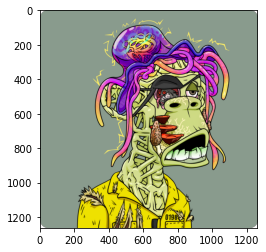

In [62]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

path = "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/"

dir_img = path + '1.png'
img = imageio.imread(dir_img)
img_np = np.array(img)
plt.imshow(img_np)
plt.show()

In [112]:
import numpy as np
from PIL import Image

def get_price(contractAddress, tokenid, roundto):
    response = json.loads(getNFTSales(contractAddress,tokenid).content)
    res = int(response['nftSales'][-1]['sellerFee']['amount'])/ (10**int(response['nftSales'][-1]['sellerFee']['decimals']))
    res = round(res, roundto)
    return res


image_data = np.zeros((500, 1262, 1262, 3), dtype=np.uint8)
price_data = np.zeros(500, dtype=np.float32)

curr = 1

for i in range(1,501):   
    
    try:
        price = get_price('0x60E4d786628Fea6478F785A6d7e704777c86a7c6', i, 5)
        
    except:
        print(i)
        continue
    
    
    # 构造图片路径
    image_path = "/Users/huohongyi/Desktop/BlockchainData/IPFS_interface/Monkeys/{}.png".format(i)
    # 使用Pillow库打开图片
    image = Image.open(image_path)
    # 将图片转换为RGB模式
    image = image.convert("RGB")
    # 将图片转换为numpy数组，并存储到三维数组中
    image_data[curr-1] = np.array(image)
    price_data[curr-1] = price
    curr+=1    
    
# 显示第一张图片的RGB值
print(image_data[0])



4
11
36
37
40
51
54
81
104
123
131
141
155
168
170
185
213
223
232
253
260
261
268
298
299
309
310
311
325
326
327
328
332
349
353
354
355
363
366
368
370
372
380
404
426
432
434
439
448
455
456
496
498
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [113]:
print(curr) #449

448


In [114]:
num=0
for i in range(500):
    if price_data[i] != 0:
        num+=1
print(num)

447


In [121]:
print(price_data[0])

6.65


# idx： 0 到 447 有东西，448之后没内容


In [97]:
# import numpy as np
# import pickle

# # 创建一个numpy数组
# my_array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# # 将数组保存为pickle文件
# with open("my_array.pickle", "wb") as f:
#     pickle.dump(my_array, f)


In [116]:
import numpy as np
import pickle

# 将image_data数组保存为pickle文件
with open("image_data.pickle", "wb") as f:
    pickle.dump(image_data, f)

In [117]:
import numpy as np
import pickle

# 将price_data数组保存为pickle文件
with open("price_data.pickle", "wb") as f:
    pickle.dump(price_data, f)

In [6]:
import numpy as np
import pickle

# 从pickle文件中加载数组
with open("price_data.pickle", "rb") as f:
    array2 = pickle.load(f)

# 打印数组
print(array2)

[6.650000e+00 2.090000e+01 1.430000e+01 4.750000e+00 2.565000e+01
 1.643500e+01 2.318000e+01 2.530750e+01 7.600000e+00 3.123600e+01
 1.283550e+01 1.947500e+01 6.175000e+00 5.177500e+00 1.708100e+01
 1.330000e+01 3.325000e+01 1.183400e+01 2.375000e+01 8.455000e+00
 1.387000e+01 1.337489e+01 1.327171e+01 2.165050e+01 8.550000e+00
 6.868500e+00 1.752750e+01 3.705000e+00 5.225000e+00 1.172300e+01
 5.937500e+00 7.505000e+00 5.320000e+00 2.200000e+01 1.733977e+01
 1.045000e+01 2.660000e+01 1.400000e+01 1.277083e+01 2.089050e+01
 1.520000e+01 1.818300e+01 1.558000e+01 2.755000e+01 1.610000e+01
 5.700000e+00 1.605500e+01 1.319360e+01 1.814500e+01 2.850000e+01
 6.555000e+00 1.260665e+01 2.080500e+01 5.367500e+00 2.196500e+01
 3.492000e+01 4.560000e+00 2.310000e+01 1.646725e+01 1.520000e+01
 6.602500e+00 1.710000e+01 1.158050e+01 6.365000e+00 1.329050e+01
 1.709997e+01 1.789000e+01 4.370000e+01 1.205550e+01 1.330216e+01
 4.750000e+00 1.312306e+01 1.097600e+01 4.446000e+00 1.320236e+01
 8.056000e

In [5]:
import numpy as np
import pickle

# 从pickle文件中加载数组
with open("image_data.pickle", "rb") as f:
    array1 = pickle.load(f)

# 打印数组
print(array1)


[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0

In [98]:
import os
cwd = os.getcwd()
print(cwd)


/Users/huohongyi/Desktop/BlockchainData/RGB Analyze 


In [109]:
import os

# 指定要删除的文件路径
file_path = "image_data.pickle"

# 使用os模块删除文件
if os.path.exists(file_path):
    os.remove(file_path)
    print("文件已成功删除")
else:
    print("文件不存在")


文件已成功删除


In [123]:
print(get_price('0x60E4d786628Fea6478F785A6d7e704777c86a7c6',122,5))

22.325


In [149]:
list = [1,2]
l = [23,34,45,46,56]
print('\t' , 1) 

print(*list)

	 1
1 2


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load image data and price data
array1 = np.array(array1)
array2 = np.array(array2)

# Use PCA to reduce feature dimensionality
pca = PCA(n_components=100)
X = pca.fit_transform(array1.reshape(array1.shape[0], -1))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, array2, test_size=0.2, random_state=42)

# Use stratified sampling to reduce training set size
sample_size = 500
classes = np.unique(y_train)
X_train_sampled = np.zeros((sample_size * len(classes), X_train.shape[1]))
y_train_sampled = np.zeros(sample_size * len(classes))
for i, c in enumerate(classes):
    class_indices = np.where(y_train == c)[0]
    sampled_indices = np.random.choice(class_indices, size=sample_size, replace=False)
    X_train_sampled[i*sample_size:(i+1)*sample_size] = X_train[sampled_indices]
    y_train_sampled[i*sample_size:(i+1)*sample_size] = y_train[sampled_indices]

# Train random forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=10)
rf.fit(X_train_sampled, y_train_sampled)

# Calculate feature importances
importances = rf.feature_importances_
print(importances)

# Calculate correlation coefficients
corr_coef = np.corrcoef(X_train_sampled.T, y_train_sampled)
print(corr_coef)


In [ ]:
import numpy as np
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
X = np.load('image_data.npy')
y = np.load('price_data.npy')

# Reduce dimensionality using PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X.reshape(X.shape[0], -1))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Sample a subset of the training data
train_idx = np.random.choice(X_train.shape[0], size=1000, replace=False)
X_train = X_train[train_idx]
y_train = y_train[train_idx]

# Train SVM model
svm_model = svm.SVR(kernel='rbf', C=10, gamma=0.01)
svm_model.fit(X_train, y_train)

# Evaluate model
test_score = svm_model.score(X_test, y_test)

# Calculate correlation coefficients
corr_coef = np.corrcoef(X_pca.T, y)
print(corr_coef)



In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np

# Load and preprocess dataset
X = np.load('image_data.npy')
y = np.load('price_data.npy')

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define neural network architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test)

# Make predictions
y_pred = model.predict(X_test)


In [124]:
print(i)

499


In [ ]:
# print(len(features), len(labels))